In [1]:
import os
import cv2

import numpy as np
import pyodbc as pyd
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import image as img
from PIL import Image

# os.chdir('..')

from data_processing.transforms import transforms
from SQL.connector import connector

In [2]:
# Preparing connection with SQL Server - Grabbing all label data with boxes, only for visualization purpose (only images with labeled faces)

query = f'SELECT * FROM dbo.label'

# 2nd version - with connectionString
# connectionString = r'Driver={ODBC Driver 18 for SQL Server};Server={JACOBE_DESKTOP\\EXPERIMENT_DATA};Database={expression};Trusted_Connection=yes'

# Listing images in subsets
database_dir = "D:\\Repos\\Face_Detection_PyTorch\\dataset\\expression_dataset\\data\\data"

# This variable will list all images - even without labels
# image_dirs = os.listdir(database_dir + "\\image\\origin")

conn = connector()
db = conn.query(query)

print(db)

d:\Repos\Face_Detection_PyTorch\SQL\connector.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, connection)


                              image face_id_image box_top box_left box_right  \
0           distaste_mother_319.jpg             3     120      664       712   
1           distaste_mother_498.jpg             1     175      103       150   
2            distaste_mother_58.jpg             0      72       88       136   
3           distaste_mother_623.jpg             0     254        5        72   
4           distaste_mother_667.jpg             0      67      180       315   
...                             ...           ...     ...      ...       ...   
91788  surprised_expression_546.jpg             0      70       70       351   
91789  surprised_expression_381.jpg             0      51       61       117   
91790  surprised_expression_395.jpg             0      27       95       258   
91791         ecstatic_asian_31.jpg             0      60      136       184   
91792  surprised_expression_394.jpg             0      47       38       152   

      box_bottom box_confidence label  

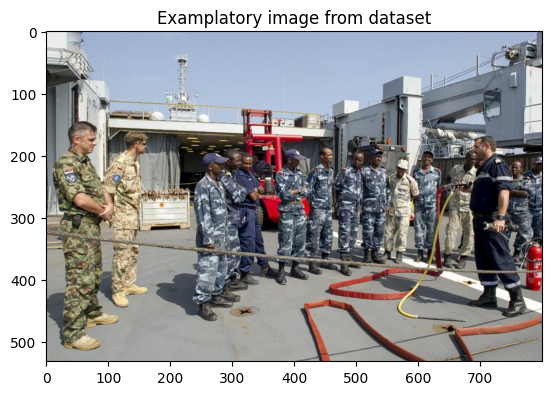

In [3]:
# For now manual choice of dataset (keep up with the directories)
example_fig = plt.figure()
example_ax = example_fig.add_subplot()

# Init for transforms
tef = transforms()

# Showing example image (you can add transform to it, for example rotate with cv2)
plt.title("Examplatory image from dataset")
rand= np.random.choice(db['image'])
random_pic = database_dir + "\\image\\origin\\" + rand
image = img.imread(random_pic)
example_ax.imshow(tef.rotate_scale(image, 0))
plt.show()

In [4]:
# Here was older approach with getting data from SQL Server every time when we visualize something
# driver = '{ODBC Driver 18 for SQL Server}'
# server = r'JACOBE_DESKTOP\EXPERIMENT_DATA'
# db = 'expression'
# uid = ''
# passwd = ''
# data_query = f'SELECT * FROM dbo.label WHERE image = {rand}'

# # connectionString = r'Driver={ODBC Driver 18 for SQL Server};Server={JACOBE_DESKTOP\\EXPERIMENT_DATA};Database={expression};Trusted_Connection=yes'

# connection = pyd.connect(driver = driver, host = server, database = db, trusted_connection = 'yes')
# cursor = connection.cursor()

# cursor.execute(data_query)
# data=cursor.fetchall()

# database = pd.read_sql(data_query, connection)

# connection.close()

# print(database)

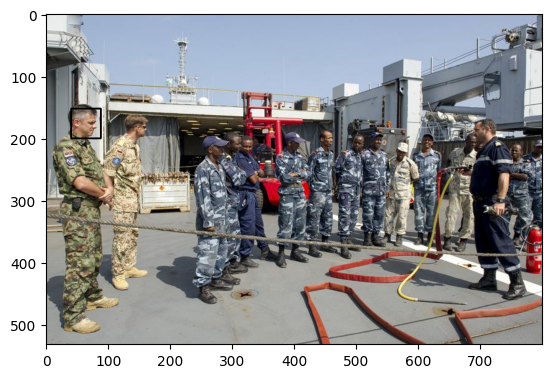

In [5]:
# Grabbing list of avalible faces in the image
faces = db.index[db['image'] == rand].tolist()

# Converting type to display
image = image.astype(int)
box_fig = plt.figure()
box_ax = box_fig.add_subplot()

# Plotting images with faces marked
for idx in faces:
    cv2.rectangle(image, (int(db['box_left'][idx]), int(db['box_top'][idx])), (int(db['box_right'][idx]), int(db['box_bottom'][idx])), (0, 0, 0), 2)
plt.imshow(image)
plt.show()
cv2.destroyAllWindows()

(40, 152, 88, 200)


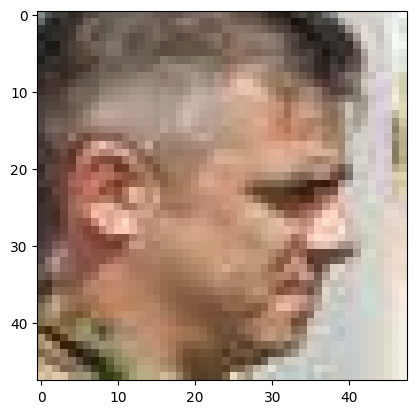

In [6]:
# Cropping image to show distinct faces as distinct images
for img in faces:
    imag = Image.open(random_pic)
    box = (int(db['box_left'][img]), int(db['box_top'][img]), int(db['box_right'][img]), int(db['box_bottom'][img]))
    print(box)
    crop_pic = imag.crop(box)
    plt.imshow(crop_pic)
    plt.show()

((26, 26), (26, 26))


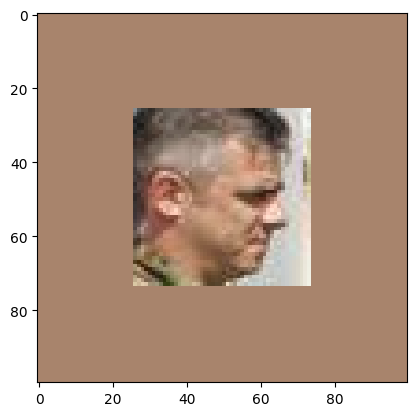

In [8]:
# image = image.astype(int)
# image = np.moveaxis(image, 2, 0)
# Int rounding toward zero
# Padding images
# Setting width/heigth for desired size
max = 100
min = 100

# For all faces in image
for img in faces:
    # Loading image and boxes and cropping it to face
    imag = Image.open(random_pic)
    box = (int(db['box_left'][img]), int(db['box_top'][img]), int(db['box_right'][img]), int(db['box_bottom'][img]))
    crop_pic = imag.crop(box)

    # Moving axis, because format in database (x, y, dim) --> we want (dim, x, y) for processing
    imag = np.moveaxis(np.array(crop_pic), 2, 0)

    # Calculating size of pads (covering both width and heigth even though the crops are squares)
    # Just in case if the database would change or something similar
    pad_vert = (max - imag.shape[1]) / 2
    pad_horz = (min - imag.shape[2]) / 2

    # Checking for not natural numbers (and fixing sizes with + 1)
    # e.g. pad = 29.5 --> one side = 29, second side = 30
    if pad_horz % 2 == 0 or pad_horz % 2 == 1:
        pad_right = int(pad_horz)
        pad_left = int(pad_horz)
    else:
        pad_right = int(pad_horz) + 1
        pad_left = int(pad_horz)

    if pad_vert % 2 == 0 or pad_horz % 2 == 1:
        pad_bottom = int(pad_vert)
        pad_top = int(pad_vert)
    else:
        pad_bottom = int(pad_vert) + 1
        pad_top = int(pad_vert)

    # Setting tuple pads
    pads = ((pad_left, pad_right), (pad_top, pad_bottom))
    print(pads)

    # Preparing processed image size and padding with numpy (with median fill)
    img_arr = np.ndarray((3,max,min),int)
    for i, x in enumerate(imag):
        cons = int(np.median(x))
        x_p = np.pad(x, pads, 'constant', constant_values=cons)
        img_arr[i,:,:] = x_p

    plt.imshow(np.moveaxis(img_arr, 0, 2))
    plt.show()

In [9]:
# This one was for cropping with cv2, but it was a little "unwieldy", so it is depriciated 
# for img in database.index:
#     crop_pic = pic[int(database['box_right'][img]):int(database['box_left'][img]), int(database['box_top'][img]):int(database['box_bottom'][img])]
#     plt.imshow(crop_pic)
#     plt.show()

In [21]:
# Something was suspicious about size of max image, so checking it to verify it
# Searching for max size and wrtitng it to array
# I want to see how the sizes changed
vert_max = [0]
horz_max = [0]
idx_max = [0]
for idx in db.index:
    horz = abs(int(db['box_left'][idx]) - int(db['box_right'][idx]))
    vert = abs(int(db['box_bottom'][idx]) - int(db['box_top'][idx]))
    if horz > horz_max[-1]:
        horz_max.append(horz)
        idx_max.append(idx)
    if vert > vert_max[-1]:
        vert_max.append(vert)

print(f"Sizes of max images through search: \n {horz_max} \n {vert_max}")

print(f"Indexes of these images: \n {idx_max}")

Sizes of max images through search: 
 [0, 48, 67, 135, 160, 228, 461, 765, 922, 924, 1127, 1870, 1872, 2117] 
 [0, 48, 67, 135, 160, 228, 461, 765, 922, 924, 1127, 1870, 1872, 2117]
Indexes of these images: 
 [0, 0, 3, 4, 14, 18, 23, 115, 170, 433, 943, 1012, 18553, 39375]


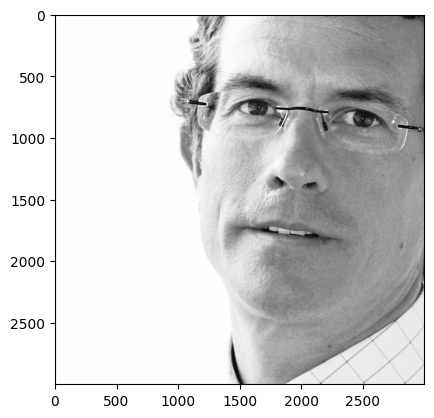

In [27]:
# Showing max images
max_imag = Image.open(database_dir + "\\image\\origin\\" + db['image'][idx_max[-1]])
plt.imshow(max_imag)
plt.show()

So we have some high resolution images that are all right, but in comparison to low res (100px) images of croped faces, it can mess the network a little, so there will be needed a good way to process the database. I will try first with padding to max, then eventually I will change it to resizing or resampling.